In [1]:
import os
import torch
import numpy as np
import torch.nn as nn

'''
Change these arguments to change either the dataset / model / loss function / types of augmentations.
The augmentations mentioned in augment_list shall be applied sequentially to generate a positive pair for contrastive training.
Make sure to not add too many augmentations as that would change the fundamental structure of the input graph.
'''
args = {
    "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save" : "ssl_model",
    "lr" : 0.001,
    "epochs" : 600,
    "batch_size" : 64,
    "num_workers" : 2,
    "dataset" : "DLPFC", # Choices are :
    "model" : "gcn", # choices are ["gcn", "gin", "resgcn", "gat", "graphsage", "sgc"]
    "feat_dim" : 128,
    "layers" : 2,
    "loss" : "DGI", # choices are :
    "aug_type":1,# 0:feature_oriented, 1: structure_oriented, 2: both
    "augment_list" : "EdgePerturbation"
    # choices are ["EdgePerturbation", "Diffusion", "RWSample", 
    # "node_dropping", "random_shuffling", "NodeAttrMask"],
}

class AttributeDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttributeDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttributeDict(args)


In [3]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'adj_new'

In [3]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import graph_aug as gu
import multiprocessing as mp
from preprocess import preprocess_adj, preprocess_adj_sparse, preprocess, construct_interaction, add_contrastive_label, get_feature,  fix_seed
#from temp_g_model import temp_g_model
from training import my_model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_clusters = 7
file_fold = 'DATA/'
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()# define and train model
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
edge_index=construct_interaction(adata)
add_contrastive_label(adata)
feat=gu.augmentation(adata,edge_index,aug_type=args.augment_list)
model = my_model(adata,args, device=device)
adata ,loss= model.train_model()
# set radius to specify the number of neighbors considered during refinement
radius = 50

# clustering
from utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=True) #For DLPFC dataset, we use optional refinement step.

df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('ARI:', ARI)
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)


/home/roxana/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


EdgePerturbation: drop


/home/roxana/My_projects/SRT_MO_NAR/Python_code/GraphST/graph_aug.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


EdgePerturbation: drop
Begin to train ST data...


100%|█████████████████████████████████████████| 600/600 [06:07<00:00,  1.63it/s]


Optimization finished for ST data!
EdgePerturbation: drop


100%|█████████████████████████████████████████| 600/600 [06:07<00:00,  1.63it/s]


Optimization finished for ST data!


R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


/home/roxana/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


ARI: 0.6577440631510565


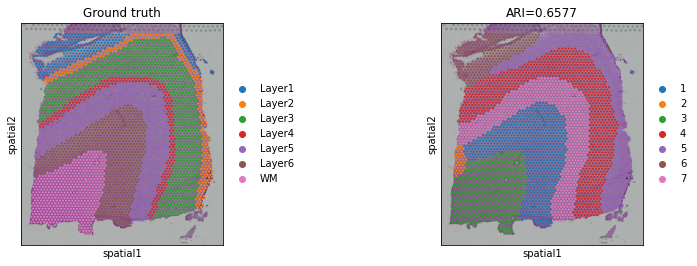